# Demo for ResNet-50

This is an example to show how to use Excitation Backprop to visualize CNN classifier's top-down attention.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, filters
import sys, pylab, operator, csv
import util
import os
import urllib
%matplotlib inline

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe

We first load the model files and set the top layers' name.  
__You need to first download the [ResNet-50](https://onedrive.live.com/?authkey=%21AAFW2-FVoxeVRck&id=4006CBB8476FF777%2117887&cid=4006CBB8476FF777) model file to the folder specified below.__

In [2]:
caffe.set_mode_gpu()
net = caffe.Net('../models/resnet50/ResNet-50-deploy.prototxt',
                '../models/resnet50/ResNet-50-model.caffemodel',
                caffe.TRAIN)
tags,tag2ID = util.loadTags('../data/ilsvrc12/synset_words.txt')
param = dict()
imgScale = 224
topBlobName = 'fc1000'
topLayerName = 'fc1000'
secondTopLayerName = 'pool5'
secondTopBlobName = 'pool5'

Current implmentation for __ScaleLayer__ assumes that the scales are all positive. Therefore, we invert all the negative scales in the scale layers and change the corresponding conv layer params accordingly. This will not result in any difference in the output of the model.  

In [3]:
for r in net.params.keys():
    if r[:5] == 'scale':
        if np.any(net.params[r][0].data<0):
            net.params['res' + r[5:]][0].data[net.params[r][0].data<0,...] *= -1
            net.params[r][0].data[...] = np.abs(net.params[r][0].data)

We load an image. 
The image is resized to 224 for the shortest dimension.
Since the provided CNN model is converted to a fully convolutional model, we can input images of arbitrary aspect ratio.

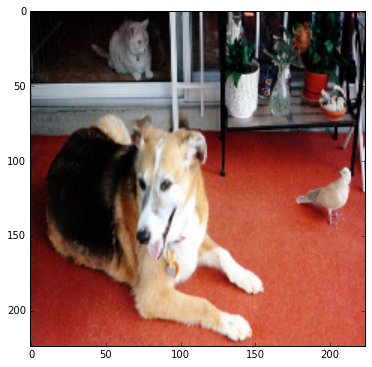

In [4]:
imgName = 'http://farm8.staticflickr.com/7204/6800351130_6d0fe31983.jpg'
img = caffe.io.load_image(imgName)
minDim = min(img.shape[:2])
newSize = (224,224)
#newSize = (int(img.shape[0]*imgScale/float(minDim)), int(img.shape[1]*imgScale/float(minDim)))
imgS = transform.resize(img, newSize)
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(imgS)

We do a forward pass and show the top predictions.

In [5]:
net.blobs['data'].reshape(1,3,newSize[0],newSize[1])
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', np.array([103.939, 116.779, 123.68]))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

net.blobs['data'].data[...] = transformer.preprocess('data', imgS)
out = net.forward(end = topLayerName)

scores = net.blobs[topBlobName].data[0].reshape((len(tags),-1)).max(1).flatten() # pre-softmax scores
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key = operator.itemgetter(1), reverse = True)
print(tagScore[:10])

[('n02106030 collie', 0.21020469), ('n02090622 borzoi', 0.16927446), ('n02109961 Eskimo dog', 0.073359795), ('n02091134 whippet', 0.061086219), ('n02110185 Siberian husky', 0.027551368), ('n04200800 shoe shop', 0.026976857), ('n02091831 Saluki', 0.025262168), ('n02105855 Shetland sheepdog', 0.023975095), ('n02110063 malamute', 0.022517707), ('n04517823 vacuum', 0.020688105)]


Now we try to visualize several object categories present in this image using our contrastive attention formulation.  

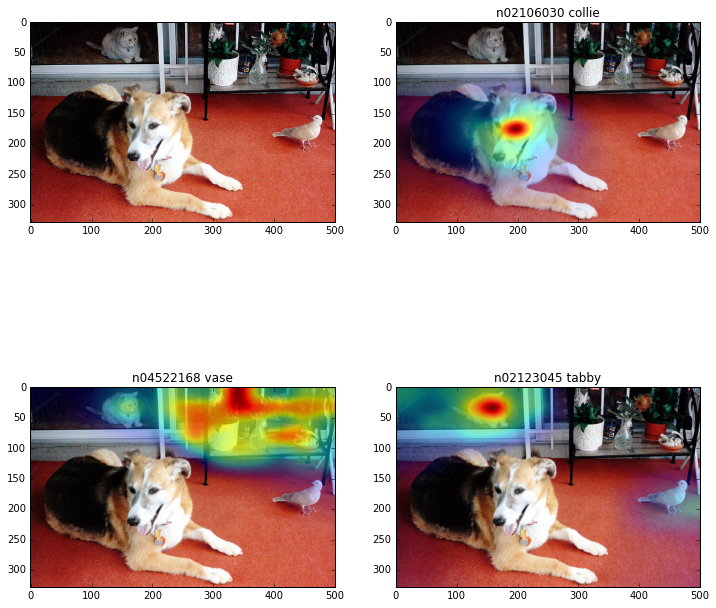

In [6]:
# switch to the excitation backprop mode
caffe.set_mode_eb_gpu() 
# specify the tags
tagName = ['n02106030 collie', 'n04522168 vase', 'n02123045 tabby']
#specify the output layer name
outputLayerName = 'res4a'#'inception_5b/output'
outputBlobName = 'res4a'#'inception_5b/output'

attMaps = []

for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID].copy())
    net.blobs[topBlobName].diff[0][tagID] /= net.blobs[topBlobName].diff[0][tagID].sum()

    # invert the top layer weights
    net.params[topLayerName][0].data[...] *= -1
    out = net.backward(start = topLayerName, end = secondTopLayerName)
    buff = net.blobs[secondTopBlobName].diff.copy()

    # invert back
    net.params[topLayerName][0].data[...] *= -1 
    out = net.backward(start = topLayerName, end = secondTopLayerName)

    # compute the contrastive signal
    net.blobs[secondTopBlobName].diff[...] -= buff

    out = net.backward(start = secondTopLayerName, end = outputLayerName)
    attMap = np.maximum(net.blobs[outputBlobName].diff[0].sum(0), 0)
    attMaps.append(attMap)

util.showAttMap(img, attMaps, tagName, overlap = True, blur = False)


We also compare with the deconvolution method.

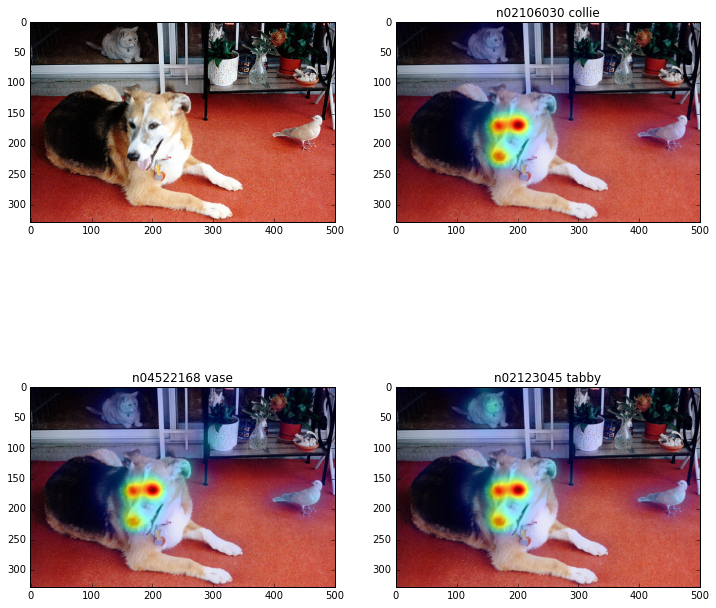

In [7]:
# switch to the deconvolution mode
caffe.set_mode_dc_gpu() 
attMaps = []
for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID])
    out = net.backward(start = topLayerName)
    attMap = np.abs(net.blobs['data'].diff[0]).max(0)
    attMaps.append(attMap)
    
util.showAttMap(img, attMaps, tagName, overlap = True, blur = True)

Compare with the gradient method

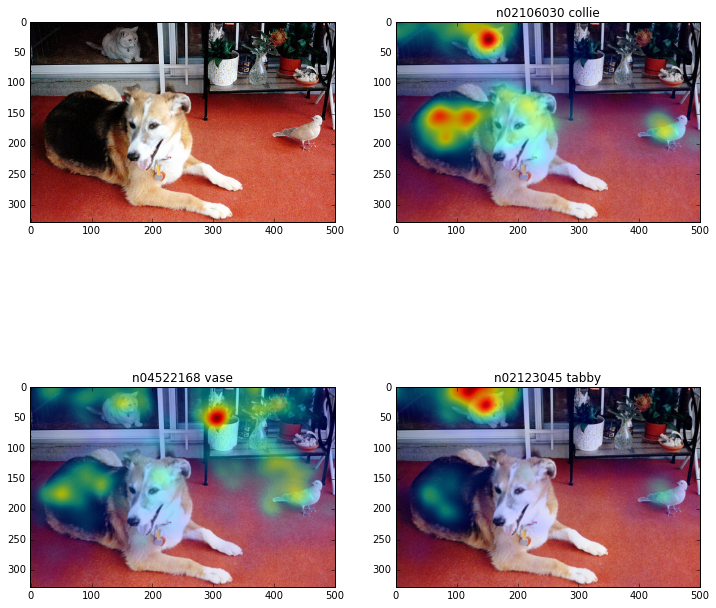

In [8]:
# Switch to the normal error backpropagation mode
caffe.set_mode_gpu() 
attMaps = []
for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID])
    out = net.backward(start = topLayerName)
    attMap = np.abs(net.blobs['data'].diff[0]).max(0)
    attMaps.append(attMap)
    
util.showAttMap(img, attMaps, tagName, overlap = True, blur = True)